In [977]:
import math
from botorch.models.model import Model
from botorch.utils import t_batch_mode_transform
from torch import Tensor
from botorch.models.model_list_gp_regression import ModelListGP
import torch
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.optim.initializers import gen_batch_initial_conditions

define the acquisition function

In [978]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: torch.Tensor,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        batch_shape = X.shape[:-2]
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.max(torch.zeros_like(u_t), u_t / self.theta) ** m, dim=-1)[0]  # b

        return scalarized_ut


check feasibility

for discrete case

In [979]:
def check_upper_bound_with_feasible_samples(model, beta: float, X: torch.Tensor, thresholds: torch.Tensor) -> (bool, torch.Tensor):
    """
    Evaluates the upper bounds of the GP model at given points and checks against thresholds.
    Additionally, returns samples from X that are feasible with respect to all objectives.

    Args:
        model (GP): The Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        X (torch.Tensor): A tensor of shape [n, d] containing `n` design points of dimension `d`.
        thresholds (torch.Tensor): A tensor of shape [o] containing threshold values for each objective.

    Returns:
        bool: Returns False if the upper bound of any objective at any point is less than the threshold, otherwise True.
        torch.Tensor: A tensor containing the subset of `X` where all objectives are feasible.
    """
    # Compute the posterior mean and covariance at X
    posterior = model.posterior(X)
    means = posterior.mean.squeeze(-2)  # Shape: [n, o]
    std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # Shape: [n, o]

    # Calculate the upper confidence bounds
    upper_bounds = means + beta * std_devs  # Shape: [n, o]

    # Check if any upper bound is below the threshold for each objective
    feasible_mask = (upper_bounds >= thresholds).all(dim=1)  # Shape: [n], True for feasible points

    # Extract feasible samples
    feasible_samples = X[feasible_mask]

    # Check if there are any feasible points
    is_feasible = feasible_mask.any()

    return (is_feasible, feasible_samples)



create constraints for each iteration(for continuous case)

TBD

In [980]:
def create_ucb_constraints(model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """

    def make_constraint(i, threshold):
        """
        Creates a constraint function for the i-th objective.

        Args:
            i (int): The index of the output dimension for which to create the constraint.
            threshold (float): The threshold value that the UCB of the i-th output should meet.

        Returns:
            Callable: A function that evaluates the constraint across a batch of design points.
        """
        def constraint(X):
            # Compute posterior at X
            posterior = model.posterior(X)
            mean = posterior.mean.squeeze(-2)[:, i]  # Extract the mean for the i-th output
            variance = posterior.variance.squeeze(-2)[:, i]  # Extract the variance for the i-th output
            ucb = mean + beta * variance.sqrt()  # Compute the UCB

            # Minimum across all points in the batch to satisfy the constraint for any single design point
            return ucb - threshold

        return constraint

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [(make_constraint(i, thresholds[i]), True) for i in range(thresholds.size(0))]

    return constraints


sphere point generator

In [981]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

In [982]:
torch.randn(2)

tensor([ 0.3476, -1.2180])

complete BO - loop

test a data set

In [983]:
import pandas
import numpy
from botorch.utils.transforms import normalize, unnormalize
data = pandas.read_table('marthedata.txt')
first_three_columns = data.iloc[:, 4:7]
two_columns = data.iloc[:, -4:-2]
numpy_array = first_three_columns.to_numpy()
numpy_array_y = two_columns.to_numpy()
# Convert the NumPy array to a PyTorch tensor
domain = torch.tensor(numpy_array)
codomain = torch.tensor(-numpy_array_y)

max_index = torch.argmax(codomain[:,0]).item()

codomain = torch.cat([codomain[:max_index,:],codomain[max_index+1:,:]],dim = 0)
domain = torch.cat([domain[:max_index,:],domain[max_index+1:,:]],dim = 0)

bounds = torch.tensor([[torch.min(codomain[:,0]).item(),torch.min(codomain[:,1]).item()], [torch.max(codomain[:,0]).item(), torch.max(codomain[:,1]).item()]])
#normalize them
codomain = normalize(codomain, bounds)

In [984]:
import random
rind = random.sample(range(0, 299), 10)

train_X = domain[rind,:]
train_Y = codomain[rind,:]

In [985]:
import numpy as np

def find_corresponding_y(X, Y, x):
    """
    Finds the output y corresponding to an input x in the dataset.

    Args:
        X (np.ndarray): An n x d matrix of input features.
        Y (np.ndarray): An n x k matrix of output features corresponding to inputs in X.
        x (np.ndarray): A 1 x d vector for which to find the corresponding output.

    Returns:
        np.ndarray: The corresponding 1 x k output vector y from Y.
    """
    # Find the index where x matches an entry in X
    # Using a norm allows us to handle floating point precision issues
    # np.isclose can also be used for a more robust floating point comparison
    indices = np.where(np.all(np.isclose(X, x), axis=1))[0]
    if indices.size > 0:
        # Assuming x is unique in X, return the first match
        return Y[indices[0]]
    else:
        # Handle the case where x is not found
        raise ValueError("The input x is not found in X.")
def F(x):
    F = find_corresponding_y(domain, codomain, x)
    return F


In [986]:
import warnings
warnings.filterwarnings('ignore')
beta =2
a = 0.7
b=  0.7
thresholds = torch.tensor([a,b])
for batch in range(50):
    model_list = []
    m = train_Y.shape[1]
    for obj in range(m):
        current_model = SingleTaskGP(train_X= train_X, train_Y= train_Y[:, obj].unsqueeze(-1))
        model_list.append(current_model)
    model = ModelListGP(*model_list)

    #test feasibility
    is_feasible, feasible_samples = check_upper_bound_with_feasible_samples(model= model, beta= beta, X=domain, thresholds= thresholds)
    if not is_feasible:
        print('declare infeasible')
        break
    #print(feasible_samples.shape[0])
    #sample theta from distribution(TBD)
    theta = get_random_sample_on_n_sphere(m,1).abs()
    #create acquisition function
    HVUCB = HyperVolumeScalarizedUCB(model= model, beta= torch.tensor(beta), theta = theta, ref= thresholds)
    #optimize constraint function
    candidate, _ = optimize_acqf_discrete(
        acq_function = HVUCB,
        choices = feasible_samples,
        q = 1,
    )
    #update data
    ##x
    train_X = torch.cat([train_X, candidate],dim=0)
    train_Y = torch.cat([train_Y, F(candidate).unsqueeze(0)], dim = 0)

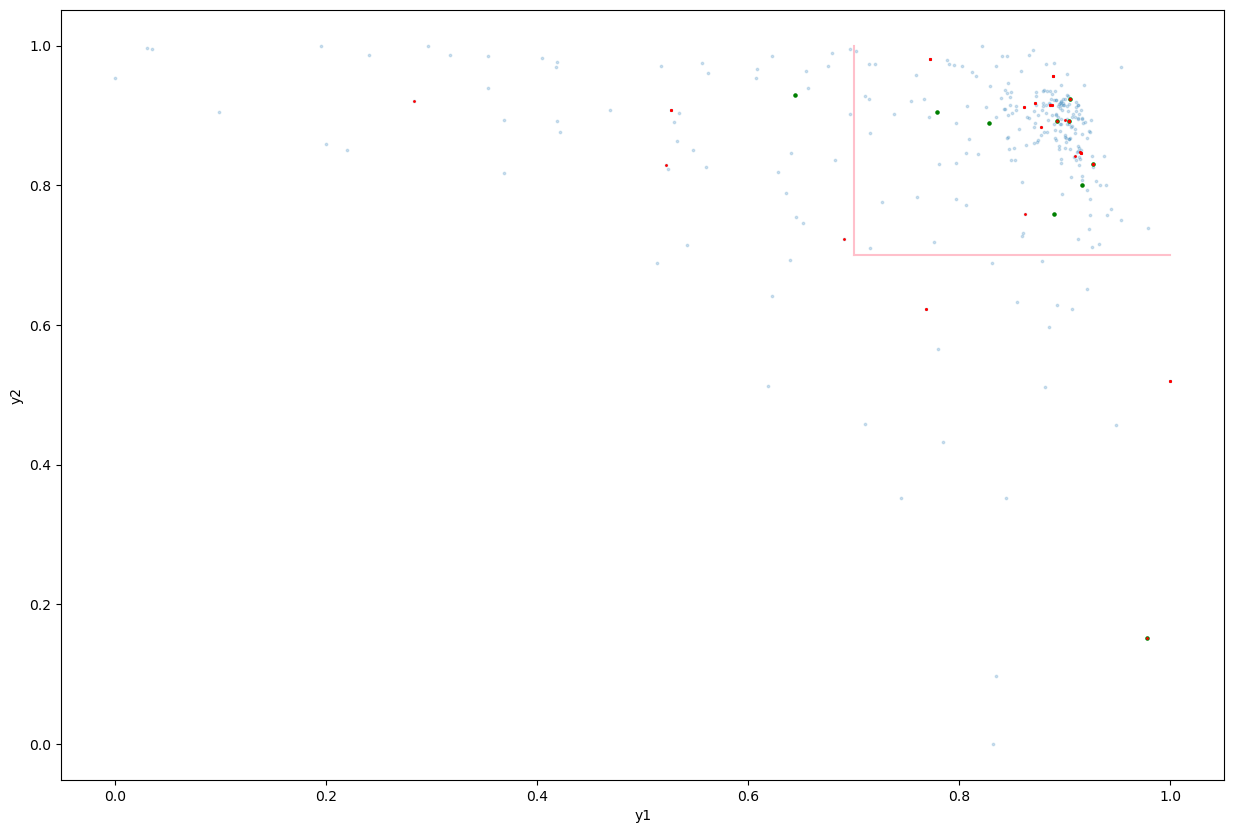

In [987]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.scatter(codomain.cpu().numpy()[:,0],codomain.cpu().numpy()[:,1],s = 3, alpha = 0.2)
ax.scatter(codomain.cpu().numpy()[rind,0],codomain.cpu().numpy()[rind,1],s = 5, c = 'green')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.scatter(train_Y.cpu().numpy()[6:,0],train_Y.cpu().numpy()[6:,1], s = 1, c = 'red')
ax.plot([a,a],[b,1], c = 'pink')
ax.plot([a,1],[b,b], c = 'pink')
plt.show()


In [988]:

print(train_Y)

tensor([[0.8897, 0.7593],
        [0.9163, 0.8006],
        [0.7794, 0.9055],
        [0.8282, 0.8885],
        [0.6442, 0.9291],
        [0.9045, 0.8919],
        [0.9784, 0.1512],
        [0.9272, 0.8298],
        [0.8929, 0.8921],
        [0.9051, 0.9240],
        [0.9157, 0.8454],
        [0.5221, 0.8282],
        [0.8885, 0.9559],
        [0.8720, 0.9183],
        [0.9045, 0.8919],
        [0.8885, 0.9559],
        [0.7688, 0.6233],
        [0.8720, 0.9183],
        [0.9045, 0.8919],
        [0.8885, 0.9559],
        [0.9272, 0.8298],
        [0.8720, 0.9183],
        [0.9045, 0.8919],
        [0.9157, 0.8454],
        [0.9272, 0.8298],
        [0.8885, 0.9559],
        [0.2838, 0.9210],
        [0.9093, 0.8413],
        [0.9157, 0.8454],
        [0.7688, 0.6233],
        [0.8773, 0.8829],
        [0.7719, 0.9808],
        [0.8883, 0.9142],
        [0.8773, 0.8829],
        [0.7719, 0.9808],
        [0.8883, 0.9142],
        [0.8612, 0.9124],
        [0.7719, 0.9808],
        [0.8

In [989]:
posterior = model.posterior(train_X)
means = posterior.mean.squeeze(-2)  # Shape: [n, o]
std_devs = posterior.variance.squeeze(dim=-2).sqrt()
upper_bounds = means + beta * std_devs

In [990]:
codomain.max(dim=0)[0]

tensor([1.0000, 1.0000], dtype=torch.float64)